# Introduction

The objective of this exercise is to generate a **baseline model** for detecting toxic text. We will use the provided training dataset. 

Furthermore, we propose enhancing the performance of this model based on **toxic language features** that can be discovered from the dataset, both in form and content, which may improve the initial dataset we have and hence the model.

# Dataset analysis

Install libraries

In [ ]:
!pip install datasets

# I stick to this version due to a recent bug when loading one pre-trained 
# model from the hub
!pip install transformers==4.28.0

### Text processing

Text is processed to achieve greater homogeneity between Twitter and news sources. Random text strings such as HTML links are also removed.

In [27]:
from datasets import Dataset
import pandas as pd
import re

# Datasets are stored in my Github account
train_df = pd.read_csv("https://raw.githubusercontent.com/jnferfer/toxic_language/main/toxicity_train_data.csv", engine="python")
test_df = pd.read_csv("https://raw.githubusercontent.com/jnferfer/toxic_language/main/toxicity_test_data.csv", engine="python")


def cleanse_text(text):

    lines = [line for line in text.split("\n") if line 
             and not re.search(r"^\s+$", line)]
    lines = [re.sub(r"\s+", " ", line.strip()) for line in lines]

    # Twitter html link removal
    lines = [re.sub(r"http\S+", "http", line) for line in lines]

    # Transform to paragraph-style text
    full_stop_lines = []
    for line in lines:
        if line[-1] not in [".", "?", "!", ":", ";", "…", "-", "—", ","]:
            full_stop_lines.append(f"{line}.")
        else:
            full_stop_lines.append(line)
    
    return " ".join(full_stop_lines)


train_df["text"] = train_df["text"].apply(lambda text: cleanse_text(text))
test_df["text"] = test_df["text"].apply(lambda text: cleanse_text(text))

Text has been transformed as follows:

In [3]:
sample_text = """
  Mañana nuestra candidata a la Xunta @Beatriz_Pino_ , estará acompañada de @Tonicanto1 y @GuillermoDiazCs en #SantiagodeCompostela #StopNacionalismo 

 Alameda 

⏰ 12:30h

  ¡Te esperamos!
#MoitoQueGañar https://t.co/fbpFEv9aiu
"""

cleanse_text(sample_text)

'Mañana nuestra candidata a la Xunta @Beatriz_Pino_ , estará acompañada de @Tonicanto1 y @GuillermoDiazCs en #SantiagodeCompostela #StopNacionalismo. Alameda. ⏰ 12:30h. ¡Te esperamos! #MoitoQueGañar http.'

### Content analysis

I want to discover distinguishing features of toxic text compared to non-toxic text. If we can accurately describe what toxic language in this dataset entails, we will learn on its dominant features and determine if they are well represented in this dataset.

To achieve this, we rely on pretrained models that predict the speaker's emotion, content, and text genre.

In [ ]:
from transformers import pipeline
from tqdm import tqdm
import torch

tqdm.pandas()

# Add emotion analysis

emotion_model = "daveni/twitter-xlm-roberta-emotion-es"

emotion_clf = pipeline(task="text-classification", framework="pt", 
                       model=emotion_model, tokenizer=emotion_model, 
                       device=torch.device("cuda:0"))

train_df["emotion"] = train_df["text"].progress_apply(
    lambda text: emotion_clf(text)[0]["label"])
test_df["emotion"] = test_df["text"].progress_apply(
    lambda text: emotion_clf(text)[0]["label"])

  0%|          | 9/11000 [00:00<02:04, 88.34it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 84%|████████▍ | 9264/11000 [01:55<00:18, 95.19it/s]

In [ ]:
# Add topic analysis, using a zero-shot classifier

zero_shot_model = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"

zero_shot_clf = pipeline(task="zero-shot-classification", model=zero_shot_model, 
                         device=torch.device("cuda:0"))

# Sketch based on news classification and tweet classification schemes
# i.e. Reuters topics and CardiffNLP Tweet topics.
sketch_topics = ['accidentes domésticos, de tráfico, desastres naturales', 
                 'arte y cultura', 'celebridades', 'ciencia, tecnología', 'deportes', 
                 'economía', 'estilo de vida, bienestar, cuidados personales', 
                 'gastronomía', 'guerras o conflictos armados', 'hobbies', 
                 'moda y estilo', 'noticias curiosas', 'noticias de religión', 
                 'películas, series, entretenimiento', 'política', 
                 'relaciones afectivas', 'viajes de ocio', 'vida cotidiana', 
                 'videojuegos']

train_df["topic"] = train_df["text"].progress_apply(
    lambda text: zero_shot_clf(text, sketch_topics, multi_label=False)["labels"][0])
test_df["topic"] = test_df["text"].progress_apply(
    lambda text: zero_shot_clf(text, sketch_topics, multi_label=False)["labels"][0])

In [ ]:
# Add genre description (opinion, instructions, news, promotion, etc.)

genre_model = "classla/xlm-roberta-base-multilingual-text-genre-classifier"

genre_clf = pipeline(task="text-classification", framework="pt", 
                       model=genre_model, tokenizer=genre_model, 
                       device=torch.device("cuda:0"))

train_df["genre"] = train_df["text"].progress_apply(
    lambda text: genre_clf(text)[0]["label"])
test_df["genre"] = test_df["text"].progress_apply(
    lambda text: genre_clf(text)[0]["label"])

# Baseline model

This code generates a baseline version of the toxic text classifier, using the provided training dataset. I have adapted the code from the following guide: https://huggingface.co/blog/sentiment-analysis-python

In [ ]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import numpy as np
from datasets import load_metric
from huggingface_hub import notebook_login

notebook_login()

# Transform dataframe format to 'datasets' library

train_ds = Dataset.from_pandas(train_df[["text", "label"]])
test_ds = Dataset.from_pandas(test_df[["text", "label"]])

# Pre-trained base model that will be fine-tuned

base_model = "bert-base-multilingual-cased"
repo_name = "toxic-lang"

# Tokenization

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenizer = AutoTokenizer.from_pretrained(base_model)
tokenized_train = train_ds.map(preprocess_function, batched=True)
tokenized_test = test_ds.map(preprocess_function, batched=True)

# Training

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

id2label = {0: "NOT_TOXIC", 1: "TOXIC"}
label2id = {"NOT_TOXIC": 0, "TOXIC": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    base_model, id2label=id2label, label2id=label2id, num_labels=2)

def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

trainer.evaluate()

trainer.push_to_hub()

# Performance analysis

The model uploaded to the hub has an F1 metric of 0.62, with room for improvement. Next, we generate predictions for the test dataset and identify those that do not match the expected label.

Additionally, we create a separate Excel file to verify the results firsthand, i.e. `test_df_with_emotion_topic_genre_ands_preds.xlsx`

In [13]:
# Load trained model from hub

toxic_clf = pipeline("text-classification", 
                     model="jnferfer/toxic-lang", device="cuda:0")

# Add predictions, compare them against truth

test_df["preds"] = test_df.progress_apply(
    lambda row: toxic_clf(row["text"])[0]["label"], axis=1)

def eval_prediction(row):
  if (row["label"] == 0 and row["preds"] == "NOT_TOXIC") or (row["label"] == 1 
                                                            and row["preds"] == "TOXIC"): 
    return "Pass"
  return "Fail"

test_df["eval"] = test_df.apply(lambda row: eval_prediction(row), axis=1)

# Write Excel file for manual evaluation

test_df.to_excel("test_df_with_emotion_topic_genre_ands_preds.xlsx", index=False)

  0%|          | 8/5000 [00:00<01:10, 70.32it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 5000/5000 [01:14<00:00, 66.87it/s]


The pretrained models (emotion, topic, and genre) we have used to describe features of toxic language can provide us with insights into the model's challenges. Regarding the source, we observe a proportion between text examples from news and Twitter.

<Axes: >

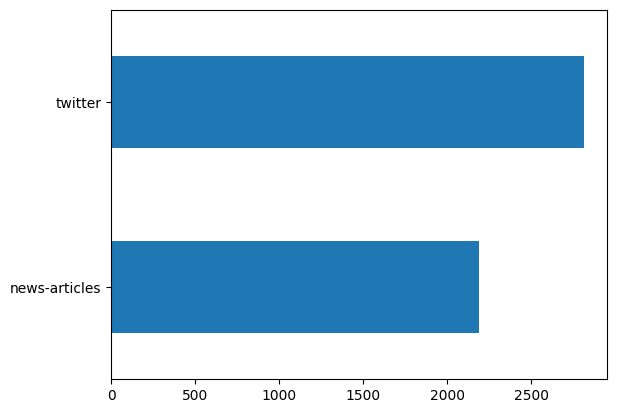

In [22]:
test_df["origin"].value_counts(ascending=True).plot.barh()

However, the failures are concentrated on Twitter, leading us to question what characteristics those Twitter texts may have that lead to errors.

<Axes: >

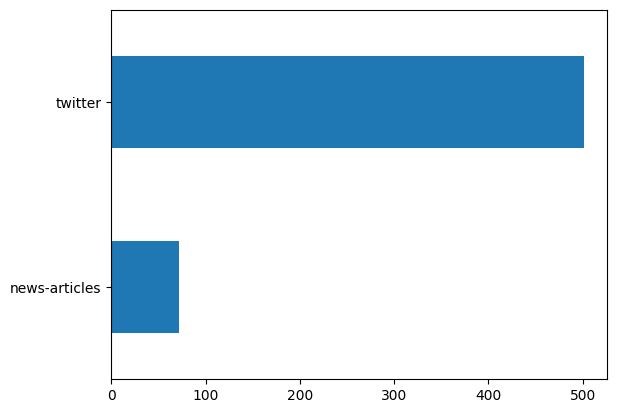

In [15]:
test_df[test_df["eval"] == "Fail"]["origin"].value_counts(ascending=True).plot.barh()

As we can see in the next graph, Twitter naturally contains a substantial amount of argumentative content. However, we come across several flaws on Twitter where texts of news genre are mistakenly presented as toxic content.

> The following example of news genre was predicted as `TOXIC`: `Castells no condena la agresión a universitarios catalanes pero pacta con ERC combatir el acoso`

> Similarly, argumentative text (opinions) poses a challenge for our model when the expression of opinion is subtle and deviates from the more conventional forms in the training dataset (first-person verbs, insults, etc.). Those tweets were labeled as `TOXIC`, too: `Desde 2008 no había 20 millones de personas ocupadas. La raya azul es el destrozo de país que fue la receta neoliberal de la "austeridad" aplicada por el bipartidismo` or `Antes que Greta que vuelva la peseta`

<Axes: >

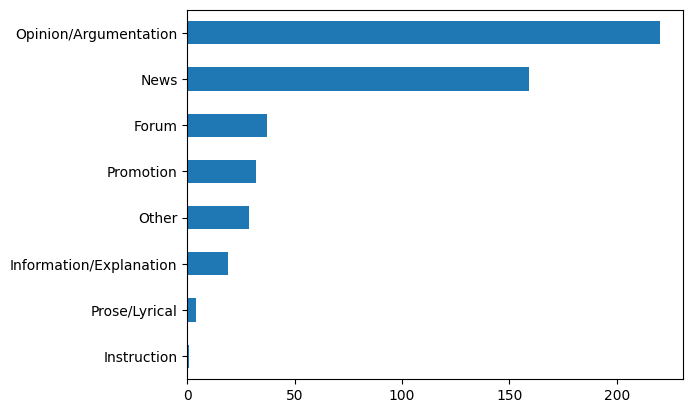

In [25]:
test_df[(test_df["eval"] == "Fail") & (test_df["origin"] == "twitter")]["genre"].value_counts(ascending=True).plot.barh()

In the subset of failures, the theme of politics stands out. This is expected since the original dataset mostly comprises text from the political domain, which commonly contains a higher amount of toxic content.

<Axes: >

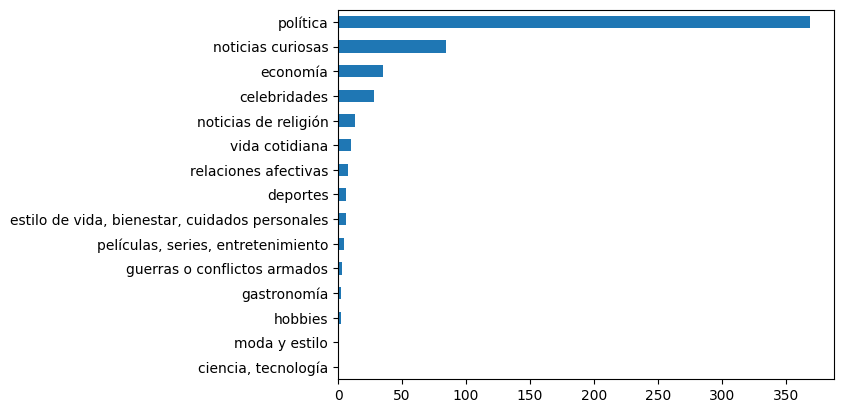

In [18]:
test_df[test_df["eval"] == "Fail"]["topic"].value_counts(ascending=True).plot.barh()

Regarding emotions, `others` is the category that accumulates the most errors. In the model we have used, it is assigned to indicate neutrality. When examining the errors of the `TOXIC` label, this neutral category poses the challenge of deviating from more conventional emotions within toxicity, such as anger or disgust, towards subtler expressions (i.e. `La casta política se ha cargado todo y amenaza con dejar esto como una tierra baldía` or `El PP llama "comunismo" a la Constitución española`)

<Axes: >

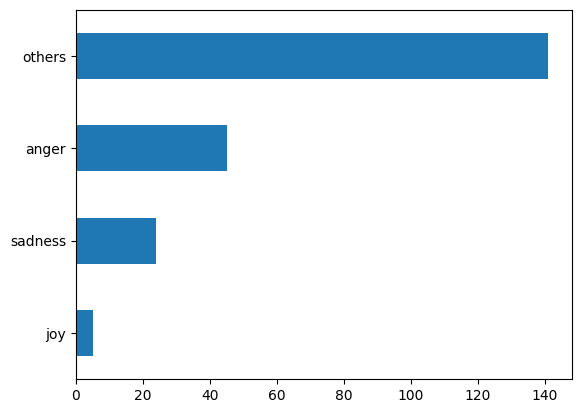

In [26]:
test_df[(test_df["eval"] == "Fail") & (test_df["label"] == 1)]["emotion"].value_counts(ascending=True).plot.barh()

### Improvements

In conclusion, we propose as a work strategy an improvement of the model focused on **expanding our original dataset**, towards the point points of toxicity detection, leveraging valuable clues from observed features in toxic text. Specifically, for the cases where the model fails, these features include:

*   Tweets containing news.
*   Unconventional forms of expressing opinion to convey toxicity (e.g., irony, sarcasm, double meanings).
*   Neutral emotions used to express toxicity, where the emphasis lies more on rhetorical figures than the expressiveness of what is being said, as in `El PP llama "comunismo" a la Constitución española`.

Using some of these previous models, we can work with **external resources** to locate these combinations of features. For instance, we can analyze political tweets or news datasets that express opinions and contain neutral emotions, where we could more easily identify sarcasm or irony that conveys toxicity. Similarly, we could employ **generative models** (GPT-x) to generate prompts for creating datasets with phrases similar to those that highlight the failures of our model.

